## [Ballistic precision](http://ballistipedia.com/index.php?title=Closed_Form_Precision) from sample targets.

We define a class `Group` that holds data on a group of shots on a target.  The shot data can be provided as a collection of (x, y) coordinates of each shot as recorded on a real target.  Or the class can generate a group by simulating random shots from a gun with a specified precision (using parameter `sigma`).

Using the shot data, `Group` calculates statistics and estimates of precision:
* Sigma, the Rayleigh distribution parameter (which also corresponds to the bivariate normal distribution with standard deviation = sigma)
* The confidence interval on the estimate of sigma
* Extreme Spread
* If the group was simulated, then we can also calculate the distance from the sample center to the true (known) center

A `plotGroup` class provides a more detailed plot of a Group than the `.plot()` method provided in the `Group` class.

We define a `OrderStatistics` subclass of `Group` that uses Order Statistics to estimate sigma.  This is a less efficient estimator, but can be easier to calculate because it doesn't require measuring the coordinates of every shot in the group.  However we have only derived Order Statistic estimators for groups of size 3, 5, or 10 shots.

We can then use "Monte Carlo" simulation to validate the statistical estimators.  Here's how that technique works: we generate large numbers of random groups using a particular parameter value, and then look at the calculated statistics to verify that they match that parameter's value.  For example, we could ask: *Is our estimator of sigma correct?*  Let's check by simulating a million groups, where each shot in each group is generated from a random variable with sigma = 1.  Calculate our sigma estimate on each group, and then look at the average of those estimates.  If our estimator is correct then its average over a large number of samples should match the parameter used to construct the samples.  So, in this example, if the average estimate of sigma is 1 then we can be confident that our estimator is correct.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import chi2

In [2]:
class Group:
    """
    Data on a group of shots.
    Computes statistical estimates of precision based on the shot data.
    """
    # Memoized values:
    cG = {}  # Gaussian correction factor
    cR = {}  # Rayleigh correction factor

    n: int                              # Number of shots in group
    sigma: float                        # Standard deviation to use if simulating shots with random variables
    degrees: int                        # Degrees of freedom (for estimators)
    shots: list[list[float]]            # Coordinates of shots [[x, y], [x, y], ...]
    sampleCenter: [float, float]        # Coordinates of centroid of group
    centeredShots: list[list[float]]    # Shots shifted so that their centroid coordinates = (0,0)
    radii: list[float]                  # Radius (distance) of each shot from centroid
    sumR2: float                        # Sum of radii squared
    sigmaEstimate: float                # Unbiased Rayleigh parameter estimate
    confidenceInterval: float           # Confidence region to calculate; default is 90%
    sigmaUpperConfidence: float         # Upper bound of confidenceInterval on sigmaEstimate

    def __init__(self, n: int, shots: list[list[float]]=[], sigma: float=1.0, confidenceInterval: float=0.9):
        """
        If no shot data provided then all simulation samples will be drawn from X,Y~N(0,sigma)
        in which case we know the true parameter we're estimating is sigma (with center at the origin)       

        :param n: Number of shots
        :param shots: List of (x,y) coordinates of each shot impact on target.
        :param sigma: standard deviation to use if simulating shots.
        :param confidenceInterval: Confidence region to calculate. Allowed range is (0,1). Default is 90%.
        """
        self.sigma = sigma
        if len(shots) > 0:
            self.shots = shots
            self.n = len(shots)
        else:  # If we didn't receive a group of shots then create random shots from bivariate normal distribution
            self.shots = [np.random.normal(scale=sigma, size=2) for i in range(0,n)]
            self.n = n

        g = 1  # Number of groups
        self.degrees = 2*(self.n-g)  # Degrees of freedom (for estimators)
        if self.n not in Group.cG:  # Compute correction factors
            d = self.degrees + 1
            Group.cG[self.n] = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
            Group.cR[self.n] = math.exp(math.log(math.sqrt(d/math.pi)) + d * math.log(4) + math.lgamma(d+1) + math.lgamma(d) - math.lgamma(2*d+1))

        self.sampleCenter = np.mean(self.shots, axis=0)
        self.centeredShots = np.add(self.shots, -self.sampleCenter) # Shots adjusted so their centroid = (0,0)
        self.radii = np.linalg.norm(self.centeredShots, axis=-1)    # List of radii from sample center
        self.sumR2 = np.dot(self.radii, self.radii)
        self.sigmaEstimate = Group.cG[self.n] * math.sqrt(self.sumR2 / self.degrees)  # Unbiased Rayleigh parameter estimate
        self.confidenceInterval = confidenceInterval
        self.sigmaUpperConfidence = math.sqrt(self.sumR2 / chi2.ppf((1-confidenceInterval)/2, self.degrees))  # Upper bound of confidence interval on estimate

        # Distance from sample center to origin (0,0).
        # CAVEAT: The origin is only known to be the *true center* if the shots were generated from Normal variables with mean = 0
        self.d2c = math.sqrt(np.dot(self.sampleCenter, self.sampleCenter))
        # Median expected distance from sample center to true center = cR * sqrt(2*math.log(2)) * sigmaEstimate / sqrt(n)
        self.d2cMedian = Group.cR[self.n] * 1.177410022515474 * self.sigmaEstimate / math.sqrt(self.n)

    def plot(self):
        """Display plot of shots.  Can call .savefig() on return value to output to file."""
        range = 1.1* np.max(np.abs(self.shots))
        plt.scatter(*zip(*self.shots))
        plt.xlim(-range, range)
        plt.ylim(-range, range)
        plt.show()

    #region Group Measures
    # Compute Extreme Spread of Group – max Euclidean distance between any two points
    # This is a brute-force algorithm. (Fastest algorithm: Find convex hull, then use Shamos's Rotating Calipers algorithm.)
    def extremeSpread(self) -> float:
        maxSpread = 0
        for i in range(0, self.n):
            for j in range(i+1, self.n):
                spread = sum(np.square(self.shots[i] - self.shots[j]))  # Sum squared distance
                if spread > maxSpread:
                    maxSpread = spread
        return math.sqrt(maxSpread)
    #endregion


### Generate and plot random group

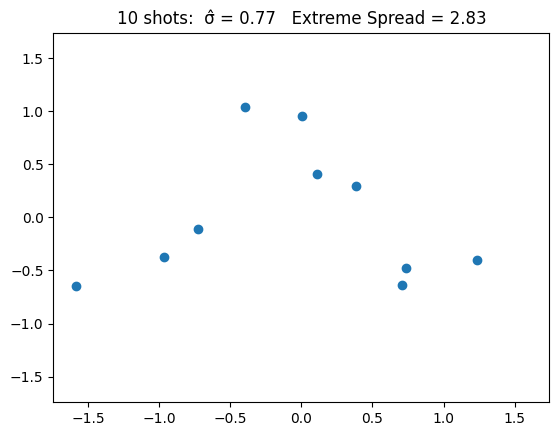

In [162]:
g = Group(10)
plt.title(f"{g.n} shots:  \u03C3\u0302 = {g.sigmaEstimate:.2f}   Extreme Spread = {g.extremeSpread():.2f}")
g.plot()

### Fancy Plot

In [158]:
import matplotlib.ticker as plticker

class plotGroup():
    def __init__(self, g: Group, CEP: float=0.5, figSize: float=1, fixedWidth: float=0):
        shots = g.shots
        center = g.sampleCenter

        self.fig = plt.figure(figsize=[figSize, figSize])

        # CEP(F) = sigma sqrt(-2 ln(1-F))
        CEPradius = math.sqrt(-2.0 * math.log(1.0-CEP)) * g.sigmaEstimate

        if fixedWidth > 0:
            width = fixedWidth
        else:
            outside = max(abs(center[0]), abs(center[1])) + CEPradius  # Range needed to fit full CEP circle on plot
            width = 1.1*max(np.max(np.abs(shots)), math.ceil(outside))  # Fit all shots as well as CEP circle
        ax = plt.axes([-width, -width, 2*width, 2*width], xlim=(-width, width), ylim=(-width, width))
        for s in ax.spines.values():
            s.set_color([0,0,0,.5])
        ax.axhline(0, color='k', lw=0.75)
        ax.axvline(0, color='k', lw=0.75)

        # Size for bullet holes
        points_whole_ax = figSize * 72 * width    # 1 point = dpi / 72 pixels
        bulletRadius = 0.04
        points_radius = 2 * bulletRadius * points_whole_ax

        plt.grid()
        # Plot Shots:
        ax.scatter(*zip(*shots), s=points_radius**2, color=[1,0,0,1])
        # Sample Center marker:
        ax.scatter(*center, s=points_radius**2, color='b', marker='+', zorder=2)
        # Plot CEP:
        ax.add_patch(plt.Circle(center, CEPradius, facecolor=[0,0,0,0], edgecolor=[0,0,0,1], zorder=1))
        # Set grid frequency to integers
        gridFreq = plticker.MultipleLocator(base=1.0)
        ax.xaxis.set_major_locator(gridFreq)
        ax.yaxis.set_major_locator(gridFreq)
        # Don't show tick labels
        ax.tick_params(labelbottom=False, labelleft=False, length=0)

        plt.figtext(0, -width, f"\nCircle shows estimated CEP({CEP:.0%}) around sample center",
                    ha='center', va='top')

        self.ax = ax


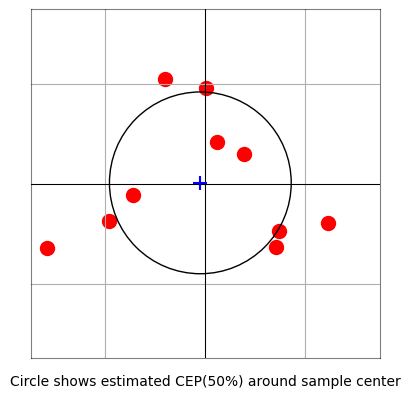

In [163]:
p = plotGroup(g)

# Simulations

In [4]:
groupSize = 5           # Number of shots per group
simulations = 100_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots

sim = [Group(groupSize, sigma=simulationSigma) for i in range(0, simulations)]  # Run simulations

### Validation of statistical estimators

In [100]:
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean([s.sigmaEstimate for s in sim]):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-sim[0].confidenceInterval)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sim if s.sigmaUpperConfidence < simulationSigma)/len(sim):.1%} of the time.\t<-- Should match"
    f"\nSample center distance from true center exceeded estimated median distance {sum(1 for s in sim if s.d2c > s.d2cMedian)/len(sim):.1%} of the time.\t<-- Should be 50%")

 *** Based on 100,000 simulated 5-shot groups: ***
Mean estimated sigma = 1.0004 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match
Sample center distance from true center exceeded estimated median distance 49.8% of the time.	<-- Should be 50%


### Validation of Order Statistics estimates

In [ ]:
class OrderStatistics(Group):
    """
    Order statistics are an alternate way of estimating sigma.
    This subclass implements the calculations so that we can validate them.
    """
    sortedShots: list[int]                  # Index of shot by radius, small to large
    orderSampleR2: float                    # Estimate of sum radii squared
    sigmaOrderStatEstimate: float           # Rayleigh parameter estimate
    sigmaOrderStatUpperConfidence: float    # Upper bound of confidenceInterval on sigmaOrderStatEstimate

    def computeOrderStatistics(self) -> float:
        """
        Compute sigma using Order Statistics approach.
        Only defined here for n = 3, 5, or 10.
        """
        def Rstat(m: int):
            """Return mth smallest radii -- i.e., order statistic R(m)"""
            if m > self.n:
                raise Exception(f"Tried to access order statistic {m} on group size {self.n}")
            return self.radii[self.sortedShots][m-1]
        
        self.sortedShots = np.argsort(self.radii)  # Index of shot by radius, small to large
        if self.n == 3:
            self.orderSampleR2 = 0.66 * Rstat(3)**2
        elif self.n == 5:
            self.orderSampleR2 = 0.7792 * Rstat(4)**2
        elif self.n == 10:
            self.orderSampleR2 = 0.4913 * Rstat(6)**2 + 0.3030 * Rstat(9)**2
        else:
            raise Exception(f"No order statistics defined for group size n={self.n}\nOnly for n = 3, 5, or 10.")
        self.orderSampleSumR2 = self.n * self.orderSampleR2
        self.sigmaOrderStatEstimate = Group.cG[self.n] * math.sqrt(self.orderSampleSumR2 / self.degrees)
        self.sigmaOrderStatUpperConfidence = math.sqrt(self.orderSampleSumR2 / (chi2.ppf(0.05, self.degrees)))
        return self.sigmaOrderStatEstimate

In [164]:
simOrderStats = [OrderStatistics(groupSize, sigma=simulationSigma) for i in range(0, simulations)]  # Run simulations
efficientEstimates = [s.sigmaEstimate for s in simOrderStats]
efficientEstimateVariance = np.var(efficientEstimates)
orderStatEstimates = [s.computeOrderStatistics() for s in simOrderStats]  # This causes each simulation to run orderStatistics
orderStatEstimateVariance = np.var(orderStatEstimates)
print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups, with true sigma {simulationSigma}: ***"
    f"\nMax. Efficiency Estimator gives mean sigma = {np.mean(efficientEstimates):.3f}  with variance = {efficientEstimateVariance:.4f}"
    f"\nOrder Statistic Estimator gives mean sigma = {np.mean(orderStatEstimates):.3f}  with variance = {orderStatEstimateVariance:.4f}"
    f"\n\tOrder Stat Efficiency is ratio of variances = {(efficientEstimateVariance/orderStatEstimateVariance):.1%}")

 *** Based on 100,000 simulated 5-shot groups, with true sigma 1.0: ***
Max. Efficiency Estimator gives mean sigma = 1.000  with variance = 0.0647
Order Statistic Estimator gives mean sigma = 1.010  with variance = 0.0822
	Order Stat Efficiency is ratio of variances = 78.7%


In [136]:
# n = 10
sim = [group(10, runOrderStatistics=True) for i in range(0,10000)]
sigmaEstimates = [s.sigmaEstimate for s in sim]
sigmaUppers = [s.sigmaUpperConfidence for s in sim]
sigmaOSestimates = [s.sigmaOrderStatEstimate for s in sim]
sigmaOSuppers = [s.sigmaOrderStatUpperConfidence for s in sim]
print(f"Sigma   mean={np.mean(sigmaEstimates):.3f}\tVar={np.var(sigmaEstimates):.3f}\t90%Confidence<Parameter={sum(1 for x in sigmaUppers if x < 1)/len(sigmaUppers):.2%}")
print(f"SigmaOS mean={np.mean(sigmaOSestimates):.3f}\tVar={np.var(sigmaOSestimates):.3f}\t90%OSConfidence<Parameter={sum(1 for x in sigmaOSuppers if x < 1)/len(sigmaOSuppers):.2%}")
print(f"\t\tOrder Stat Efficiency = {(np.var(sigmaEstimates)/np.var(sigmaOSestimates)):.3f}")

Sigma   mean=1.001	Var=0.028	90%Confidence<Parameter=4.89%
SigmaOS mean=1.001	Var=0.033	90%OSConfidence<Parameter=5.95%
		Order Stat Efficiency = 0.860


In [138]:
# n = 5
sim = [group(5, runOrderStatistics=True) for i in range(0,10000)]
sigmaEstimates = [s.sigmaEstimate for s in sim]
sigmaUppers = [s.sigmaUpperConfidence for s in sim]
sigmaOSestimates = [s.sigmaOrderStatEstimate for s in sim]
sigmaOSuppers = [s.sigmaOrderStatUpperConfidence for s in sim]
print(f"Sigma   mean={np.mean(sigmaEstimates):.3f}\tVar={np.var(sigmaEstimates):.3f}\t90%Confidence<Parameter={sum(1 for x in sigmaUppers if x < 1)/len(sigmaUppers):.2%}")
print(f"SigmaOS mean={np.mean(sigmaOSestimates):.3f}\tVar={np.var(sigmaOSestimates):.3f}\t90%OSConfidence<Parameter={sum(1 for x in sigmaOSuppers if x < 1)/len(sigmaOSuppers):.2%}")
print(f"\t\tOrder Stat Efficiency = {(np.var(sigmaEstimates)/np.var(sigmaOSestimates)):.3f}")

Sigma   mean=1.002	Var=0.064	90%Confidence<Parameter=4.79%
SigmaOS mean=1.014	Var=0.081	90%OSConfidence<Parameter=6.10%
		Order Stat Efficiency = 0.791


In [139]:
# n = 3 ... at this size a single order statistic is a very coarse estimator
sim = [group(3, runOrderStatistics=True) for i in range(0,50000)]
sigmaEstimates = [s.sigmaEstimate for s in sim]
sigmaUppers = [s.sigmaUpperConfidence for s in sim]
sigmaOSestimates = [s.sigmaOrderStatEstimate for s in sim]
sigmaOSuppers = [s.sigmaOrderStatUpperConfidence for s in sim]
print(f"Sigma   mean={np.mean(sigmaEstimates):.3f}\tVar={np.var(sigmaEstimates):.3f}\t90%Confidence<Parameter={sum(1 for x in sigmaUppers if x < 1)/len(sigmaUppers):.2%}")
print(f"SigmaOS mean={np.mean(sigmaOSestimates):.3f}\tVar={np.var(sigmaOSestimates):.3f}\t90%OSConfidence<Parameter={sum(1 for x in sigmaOSuppers if x < 1)/len(sigmaOSuppers):.2%}")
print(f"\t\tOrder Stat Efficiency = {(np.var(sigmaEstimates)/np.var(sigmaOSestimates)):.3f}")

Sigma   mean=1.000	Var=0.132	90%Confidence<Parameter=5.06%
SigmaOS mean=1.041	Var=0.149	90%OSConfidence<Parameter=4.55%
		Order Stat Efficiency = 0.884


# Fast Simulations (Cython)

In [2]:
%load_ext cython

In [3]:
%%cython
import numpy as np
import math
from scipy.stats.distributions import chi2
from libc.math cimport sqrt
cimport cython

@cython.boundscheck(False)  # Doesn't check array bounds
@cython.cdivision(True)  # Doesn't spend time checking for zero divisors
def runSim(int numShots, Py_ssize_t numSims, double sigma = 1.0, double confidenceInterval = 0.9):
    cdef double[:] sigmaEstimate = np.zeros(numSims, np.double)
    cdef double[:] sigmaUpperConfidence = np.zeros(numSims, np.double)

    cdef double[:,:,:] shots = np.random.normal(scale=sigma, size=(numSims, numShots, 2)).astype(np.double)

    cdef int degrees = 2*(numShots-1)  # Degrees of freedom (for estimators)
    cdef double d = degrees+1
    cdef double cG = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
    cdef double chiNorm = 1/chi2.ppf((1-confidenceInterval)/2, degrees)

    cdef double [:, :] centeredShots    # Shots shifted so that their centroid coordinates = (0,0)
    cdef double [:] radii = np.zeros(numShots, np.double)  # Radius (distance) of each shot from centroid
    cdef double sumR2                   # Sum of radii squared
    cdef double xbar, ybar
    cdef Py_ssize_t i, s
    for s in range(numSims):
        #sampleCenter = np.mean(shots[s], axis=0)
        xbar = ybar = 0
        for i in range(numShots):
            xbar += shots[s, i, 0]
            ybar += shots[s, i, 1]
        xbar /= numShots
        ybar /= numShots
        sumR2 = 0
        for i in range(numShots):
            sumR2 += (shots[s, i, 0] - xbar)**2 + (shots[s, i, 1] - ybar)**2
        sigmaEstimate[s] = cG * sqrt(sumR2 / degrees)    # Unbiased Rayleigh parameter estimate
        sigmaUpperConfidence[s] = sqrt(sumR2 * chiNorm)  # Upper bound of confidence interval on estimate
        
    return sigmaEstimate, sigmaUpperConfidence


In [5]:
groupSize = 5           # Number of shots per group
simulations = 10_000_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9

sigmaEstimate, sigmaUpperConfidence = runSim(groupSize, simulations,
                                              sigma=simulationSigma, confidenceInterval=simConfidence)

print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean(sigmaEstimate):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-simConfidence)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sigmaUpperConfidence if s < simulationSigma)/simulations:.1%} of the time.\t<-- Should match")

 *** Based on 10,000,000 simulated 5-shot groups: ***
Mean estimated sigma = 1.0001 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match


# Faster Multi-threaded Cython

In [6]:
%%cython
# distutils: extra_compile_args=/openmp
import numpy as np
import math
from scipy.stats.distributions import chi2
from libc.math cimport sqrt
cimport cython
from cython.parallel import prange

@cython.boundscheck(False)  # Doesn't check array bounds
@cython.wraparound(False)
@cython.cdivision(True)  # Doesn't spend time checking for zero divisors
def runSimMP(int numShots, Py_ssize_t numSims, double sigma = 1.0, double confidenceInterval = 0.9):
    cdef double[:] sigmaEstimate = np.zeros(numSims, np.double)
    cdef double[:] sigmaUpperConfidence = np.zeros(numSims, np.double)

    cdef double[:,:,:] shots = np.random.normal(scale=sigma, size=(numSims, numShots, 2)).astype(np.double)

    cdef int degrees = 2*(numShots-1)  # Degrees of freedom (for estimators)
    cdef double d = degrees+1
    cdef double cG = 1/math.exp(math.log(math.sqrt(2/(d-1))) + math.lgamma(d/2) - math.lgamma((d-1)/2))
    cdef double chiNorm = 1/chi2.ppf((1-confidenceInterval)/2, degrees)

    cdef double [:, :] centeredShots    # Shots shifted so that their centroid coordinates = (0,0)
    cdef double [:] radii = np.zeros(numShots, np.double)  # Radius (distance) of each shot from centroid
    cdef double sumR2                   # Sum of radii squared
    cdef double xbar, ybar
    cdef Py_ssize_t s, i
    for s in prange(numSims, nogil=True):#, schedule='static'):#, num_threads=4):
        #sampleCenter = np.mean(shots[s], axis=0)
        xbar = ybar = 0
        for i in range(numShots):
            xbar = xbar+ shots[s, i, 0]
            ybar = ybar+ shots[s, i, 1]
        xbar = xbar/numShots
        ybar = ybar/numShots
        sumR2 = 0
        for i in range(numShots):
            sumR2 = sumR2+ (shots[s, i, 0] - xbar)**2 + (shots[s, i, 1] - ybar)**2
        sigmaEstimate[s] = cG * sqrt(sumR2 / degrees)    # Unbiased Rayleigh parameter estimate
        sigmaUpperConfidence[s] = sqrt(sumR2 * chiNorm)  # Upper bound of confidence interval on estimate
        
    return sigmaEstimate, sigmaUpperConfidence


In [7]:
groupSize = 5           # Number of shots per group
simulations = 10_000_000    # Number of groups to simulate
simulationSigma = 1.0   # Sigma to use when generating random shots
simConfidence = 0.9

sigmaEstimate, sigmaUpperConfidence = runSimMP(groupSize, simulations,
                                              sigma=simulationSigma, confidenceInterval=simConfidence)

print(f" *** Based on {simulations:,} simulated {groupSize}-shot groups: ***"
    f"\nMean estimated sigma = {np.mean(sigmaEstimate):.4f} vs true sigma = {simulationSigma}   <-- Mean estimate should converge to true as #simulations increases"
    f"\nTrue sigma was above the upper {(1-simConfidence)/2:.0%} Confidence Interval on estimated sigma "
    f"{sum(1 for s in sigmaUpperConfidence if s < simulationSigma)/simulations:.1%} of the time.\t<-- Should match")

 *** Based on 10,000,000 simulated 5-shot groups: ***
Mean estimated sigma = 1.0001 vs true sigma = 1.0   <-- Mean estimate should converge to true as #simulations increases
True sigma was above the upper 5% Confidence Interval on estimated sigma 5.0% of the time.	<-- Should match
